> Copyright (c) 2023 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 

# Concept Probing Using Sparse Perturbations
This notebook demonstrates how the [gradient_ascent](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.perturbations.gradient_ascent.html#rai_toolbox.perturbations.gradient_ascent) function from the previous tutorial can be repurposed with a different optimizer ([L1qFrankWolfe](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.optim.L1qFrankWolfe.html)) to execute a task called concept probing.
This method of concept probing was first reported in the paper [Controllably Sparse Perturbations of Robust Classifiers for
Explaining Predictions and Probing Learned Concepts](https://diglib.eg.org/bitstream/handle/10.2312/mlvis20211072/001-005.pdf?sequence=1&isAllowed=y).

If you haven't already, follow the steps at the beginning of the previous tutorial to install the rAI-toolbox and create a Jupyter notebook called `ImageNet-Concept-Probing.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.


## Boilerplate setup

In [2]:
from functools import partial

import torch
import matplotlib.pyplot as plt

from rai_toolbox.optim import L1qFrankWolfe
from rai_toolbox.perturbations import gradient_ascent

from rai_experiments.utils.imagenet_labels import IMAGENET_LABELS

In [3]:
# CPU or GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


## Load pre-trained ImageNet models
The pre-trained models used in this example are simplified data structures of the pre-trained models available via Madrylab's robustness library [README](https://github.com/MadryLab/robustness/blob/master/README.rst) for the [ImageNet](https://www.image-net.org/) dataset, and include:

- `mitll_imagenet_l2_3_0.pt`: ResNet-50 model trained with perturbations generated via PGD using the $L^2$-norm with $\epsilon=3.0$
- `imagenet_nat.pt`: ResNet-50 model trained using standard training, i.e., $\epsilon=0$

`rai_experiments.models.pretrained.load_model` will automatically download and cache pre-trained weights for these models.

In [4]:
from rai_experiments.models.pretrained import load_model

# Load the robust model
model_robust = load_model("mitll_imagenet_l2_3_0.pt")
model_robust.eval();

# Load the standard model
model_standard = load_model("imagenet_nat.pt")
model_standard.eval();

## Concept probing

We will now demonstrate how the optimizer input to `gradient_ascent` can be switched out to complete a different task, called Concept Probing. Now instead of starting with a real image from the test set and optimizing its perturbation away from its true class as we did in the previous tutorial, in this example, we'll be starting with a random noise image and optimizing its perturbation towards a class of interest, in an attempt to visualize what the model has learned for that class.

Following the approach proposed by the authors of [this paper](https://diglib.eg.org/bitstream/handle/10.2312/mlvis20211072/001-005.pdf?sequence=1&isAllowed=y), we utilize the $L^{1-q}$ Frank-Wolfe optimizer to solve for sparse perturbations that are more interpretable by humans.

We will use `functools.partial` to set default values for `gradient_ascent`, so that they can be used consistently across our two models. Note that [AdditivePerturbation](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.perturbations.AdditivePerturbation.html#rai_toolbox.perturbations.AdditivePerturbation) is the default `perturbation_model` for `gradient_ascent`, so we don't need to define it explicitly. 

In [9]:
# Define solver for concept probing example:
solver_L1FW = partial(
    gradient_ascent,
    optimizer=L1qFrankWolfe,
    # optimizer options
    lr=1.0,
    epsilon=7760,
    q=0.975,
    dq=0.05,
    # solver options
    steps=45,
    targeted=True,
    use_best=False
)

Define three concepts to be probed (e.g., target classes), a random noise image to start with, and a function for probing those three concepts for a given model:

In [6]:
# Concepts to be probed
target_classes = [75, 17, 965]

# Random noise image
init_noise = torch.randn([1, 3, 224, 224])
init_noise = init_noise - init_noise.min()
init_noise = init_noise / init_noise.max()

# Function for probing concepts
def probe_concepts(x, target_classes, solver, model):
    _, ax = plt.subplots(2,3,figsize=(10,5))
    for i in range(3):
        # optimize loss towards target class
        target = torch.tensor([target_classes[i]])
        
        # run solver
        x_concept, _ = solver(
            model=model.to(device),
            data=x.to(device),
            target=target.to(device),
        )

        # plot
        ax[0, i].imshow(x[0].permute(1,2,0))
        ax[0, i].axis("off")
        ax[1, i].set_title(IMAGENET_LABELS[target_classes[i]].partition(",")[0])
        ax[1, i].imshow(x_concept[0].detach().cpu().clamp_(0,1).permute(1,2,0))
        ax[1, i].axis("off")

Run for standard and robust models and plot (first row is initial noise image, second row is the probed concept):

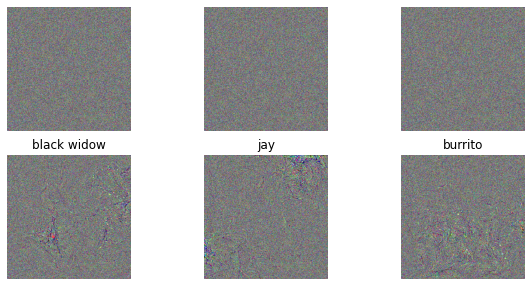

In [7]:
# Standard
probe_concepts(init_noise, target_classes, solver_L1FW, model_standard)

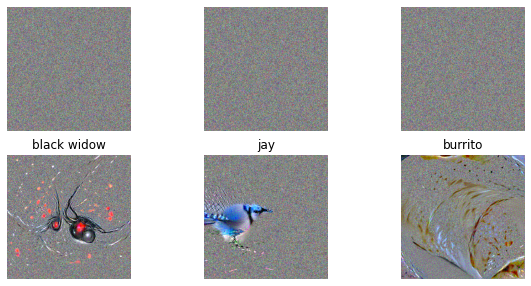

In [10]:
# Robust
probe_concepts(init_noise, target_classes, solver_L1FW, model_robust)

Note that the concepts from the robust model are much more pronounced and look like the target class to the human eye.